In [54]:
import os

import earthpy as et
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import requests
import warnings
import zipfile

warnings.filterwarnings("ignore")

In [17]:
shape_file_path = 'assets/areas/immediate_project/Zumwinkel_property.shp'
aoi_gdf = gpd.read_file(shape_file_path)

In [3]:
# Define directories and filepaths
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'treebeard')

# Data Set #1: Denver Regional Aerial Imagery Boundary
drapp_url = (
    'https://gisdata.drcog.org:8443'
    '/geoserver/DRCOGPUB/ows?'
    'service=WFS&version=1.0.0&'
    'request=GetFeature&'
    'typeName=DRCOGPUB:drapp_tile_scheme_2020'
    '&outputFormat=SHAPE-ZIP'
)
drapp_shp_file = os.path.join(data_dir, 'drapp_tile_scheme_2020', 'drapp_tile_scheme_2020.shp')
drapp_dir = os.path.join(data_dir, 'drapp_tile_scheme_2020')

# Data Set #2: Denver Regional Aerial Imagery Tiles
drapp_tiles_dir = os.path.join(data_dir, 'drapp_tiles')
os.makedirs(drapp_tiles_dir, exist_ok=True)

In [4]:
if not os.path.exists(drapp_shp_file):
    drapp_resp = requests.get(drapp_url)
else:
    print('Data already downloaded.')

Data already downloaded.


In [5]:
def extract_zip(target_dir, zip_filename, resp):
    zip_path = os.path.join(data_dir, zip_filename)
    with open(zip_path, 'wb') as f:
        f.write(resp.content)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(target_dir)

In [8]:
drapp_dir = os.path.join(data_dir, 'drapp_tile_scheme_2020')
if not os.path.exists(drapp_shp_file):
    extract_zip(data_dir, 'drapp_tile_scheme_2020.zip', drapp_resp)
else:
    print('Data already downloaded.')

Data already downloaded.


In [11]:
aoi_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
drapp_gdf = gpd.read_file(drapp_shp_file)
drapp_gdf = drapp_gdf.to_crs(aoi_gdf.crs) # EPSG:6428 -> EPSG:4326
drapp_gdf

project area      resolution     tile photo_date       storage  \
0         2020   1a  3 Inch, 6 Inch  S3E194c   20200426  drapparchive   
1         2020   1a  3 Inch, 6 Inch  S3E194d   20200426  drapparchive   
2         2020   1a  3 Inch, 6 Inch  S3E195c   20200426  drapparchive   
3         2020   1a  3 Inch, 6 Inch  S3E195d   20200426  drapparchive   
4         2020   1a  3 Inch, 6 Inch  S3E196c   20200426  drapparchive   
...        ...  ...             ...      ...        ...           ...   
10130     2020    3         12 Inch   N4W379   20200711  drapparchive   
10131     2020    3         12 Inch   N4W348   20200711  drapparchive   
10132     2020    3         12 Inch   N4W349   20200711  drapparchive   
10133     2020    3         12 Inch   N4W338   20200711  drapparchive   
10134     2020    3         12 Inch   N4W339   20200711  drapparchive   

                                                geometry  
0      POLYGON ((-104.92568 39.30538, -104.92562 39.3...  
1      POLYGON ((-104.91635 39.30534, -104.91629 39.3...  
2      POLYGON ((-104.90702 39.30529, -104.90696 39.3...  
3      POLYGON ((-104.89769 39.30524, -104.89763 39.3...  
4      POLYGON ((-104.88836 39.30519, -104.88830 39.3...  
...                                                  ...  
10130  POLYGON ((-105.39078 40.20540, -105.39075 40.2...  
10131  POLYGON ((-105.40962 40.24890, -105.40960 40.2...  
10132  POLYGON ((-105.39071 40.24888, -105.39069 40.2...  
10133  POLYGON ((-105.40960 40.26339, -105.40958 40.2...  
10134  POLYGON ((-105.39069 40.26337, -105.39066 40.2...  

[10135 rows x 7 columns]

In [14]:
drapp_aoi_gdf = gpd.sjoin(drapp_gdf, aoi_gdf, how='inner', predicate='intersects')

In [33]:
drapp_aoi_gdf

project area resolution    tile photo_date       storage  \
8979     2020    3    12 Inch  N4W351   20200711  drapparchive   

                                               geometry  index_right  \
8979  POLYGON ((-105.52309 40.23444, -105.54200 40.2...            0   

      Shape_Leng  Shape_Area  
8979    0.017313    0.000015

In [40]:
aoi_plot = aoi_gdf.hvplot(
        geo=True, tiles='OSM', alpha=1, 
        height=600, width=800, color='red',
        label='Area of Interest'
    )
drapp_plot = drapp_aoi_gdf.hvplot(
        geo=True, tiles='OSM', 
        alpha=0.3, color='blue',
        height=600, width=800,
        hover_cols=['tile', 'photo_date'],
        title='Area of Interest in DRAPP Tile N4W351'
    )
aoi_plot * drapp_plot

:Overlay
   .WMTS.I                    :WMTS   [Longitude,Latitude]
   .Polygons.Area_of_Interest :Polygons   [Longitude,Latitude]
   .WMTS.II                   :WMTS   [Longitude,Latitude]
   .Polygons.I                :Polygons   [Longitude,Latitude]   (tile,photo_date)

In [41]:
tile_base_url = 'https://drapparchive.s3.amazonaws.com/2020/'
tile_urls = [f'{tile_base_url}{tile}.tif' for tile in drapp_aoi_gdf['tile'].unique()]

In [46]:
drapp_tiles_dir = os.path.join(data_dir, 'drapp_tiles')
os.makedirs(drapp_tiles_dir, exist_ok=True)

def download_files(urls):
    paths = []
    for url in urls:
        filename = os.path.basename(url)
        path = os.path.join(drapp_tiles_dir, filename)
        paths.append(path)
        if not os.path.exists(path):
            print(f"Downloading {url}...")
            resp = requests.get(url)
            with open(path, 'wb') as f:
                f.write(resp.content)
        else:
            print(f"File {filename} already downloaded.")
    return paths
tile_paths = download_files(tile_urls)

File N4W351.tif already downloaded.


In [77]:
tile_paths[0]

'/Users/ed.chan/earth-analytics/data/treebeard/drapp_tiles/N4W351.tif'

In [74]:
photo_date = pd.to_datetime(
        drapp_aoi_gdf['photo_date']
    ).dt.date.unique()[0].strftime('%Y-%m-%d')
tile_name = drapp_aoi_gdf['tile'].unique()[0]

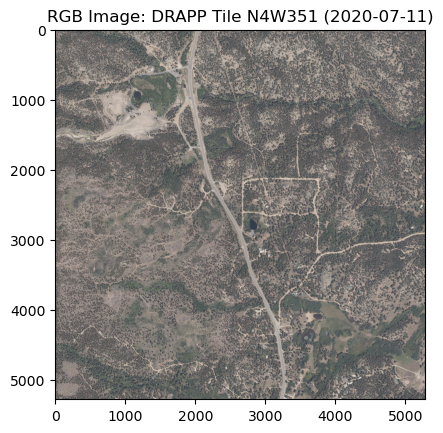

In [76]:
# Open all the files
src_files_to_mosaic = [rasterio.open(path) for path in tile_paths]
mosaic, out_trans = merge(src_files_to_mosaic)
red = mosaic[0]
green = mosaic[1]
blue = mosaic[2]
nir = mosaic[3]
rgb = np.dstack((red, green, blue))
plt.imshow(rgb)
plt.title(f'RGB Image: DRAPP Tile {tile_name} ({photo_date})')
plt.savefig('images/N4W351_rgb_image.png')
plt.show()

In [84]:
aoi_gdf

Shape_Leng  Shape_Area                                           geometry
0    0.017313    0.000015  POLYGON Z ((-105.52765 40.24538 0.00000, -105....

In [85]:
drapp_aoi_gdf

project area resolution    tile photo_date       storage  \
8979     2020    3    12 Inch  N4W351   20200711  drapparchive   

                                               geometry  index_right  \
8979  POLYGON ((-105.52309 40.23444, -105.54200 40.2...            0   

      Shape_Leng  Shape_Area  
8979    0.017313    0.000015

In [104]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# Open the GeoTIFF file
with rasterio.open(tile_paths[0]) as src:
    # Make sure the GeoDataFrame's CRS matches the raster's CRS
    if aoi_gdf.crs != src.crs:
        aoi_gdf = aoi_gdf.to_crs(src.crs)

    # Create a mask for cropping
    geom = [aoi_gdf.geometry.unary_union]  # Combines all geometries in the GeoDataFrame
    out_image, out_transform = mask(src, geom, crop=True)

    # Update the metadata for the cropped raster
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

cropped_file = "scratch/cropped_N4W351.tif"
with rasterio.open(cropped_file, "w", **out_meta) as dest:
    dest.write(out_image)


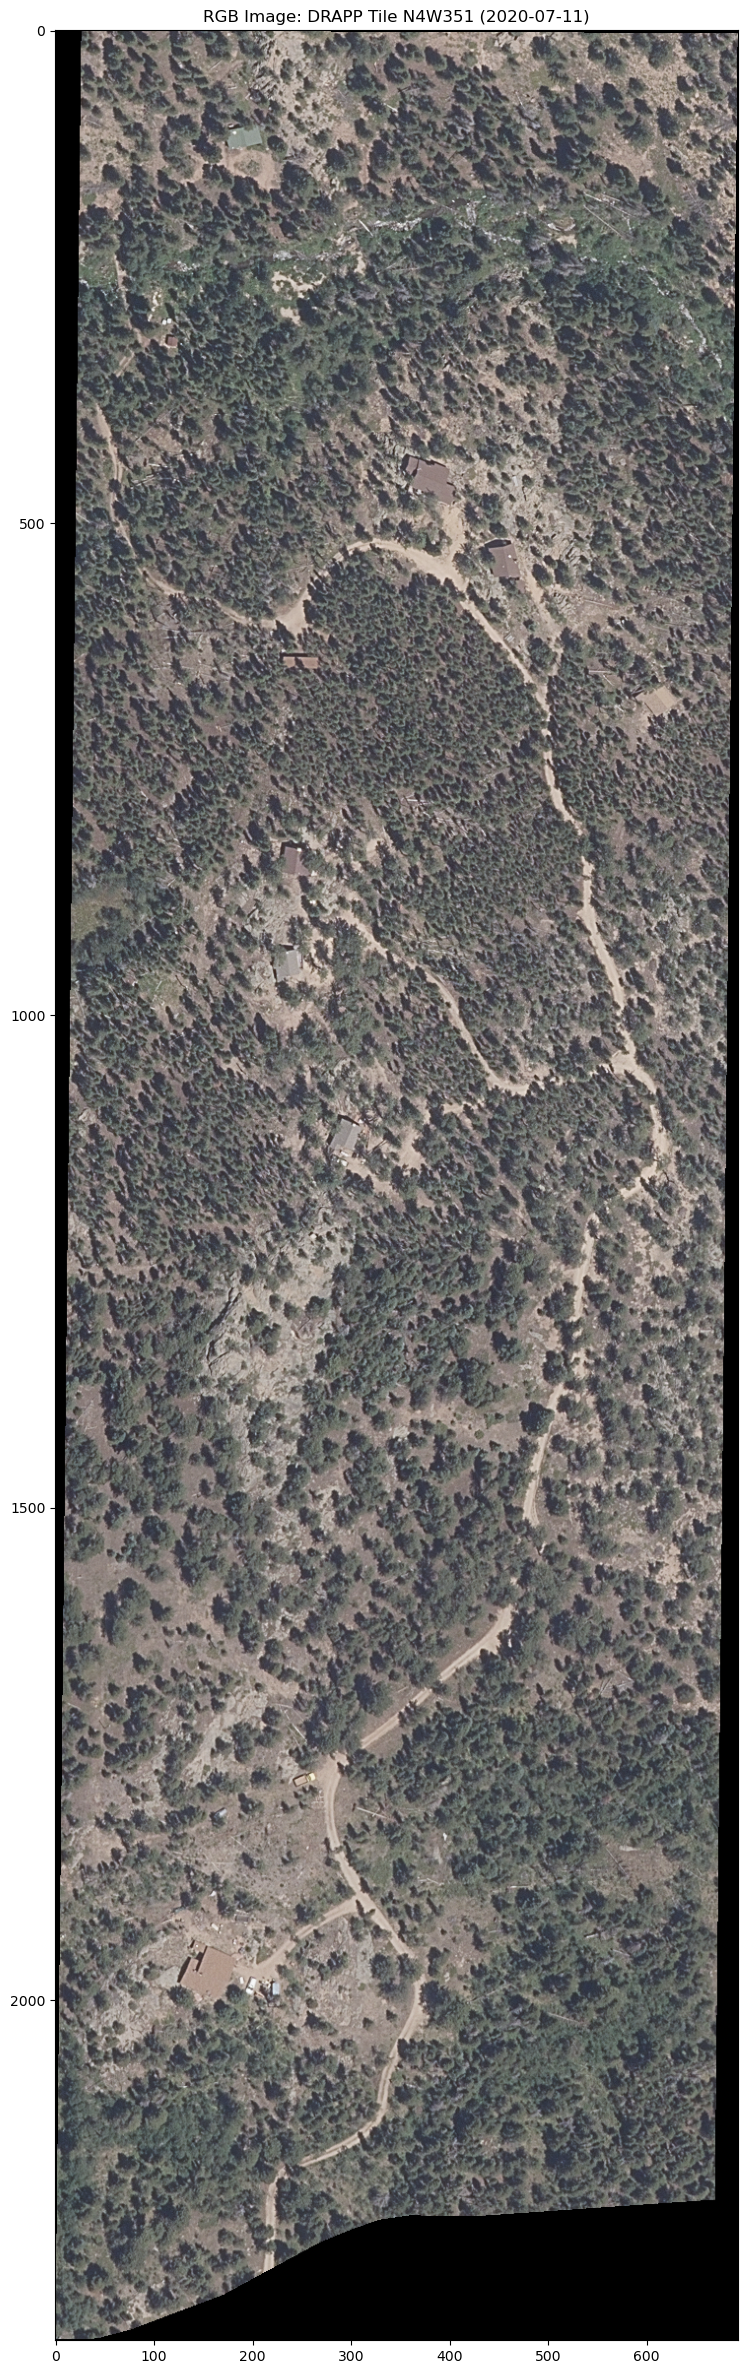

In [93]:
# Open all the files
tile_paths2 = [cropped_file]
src_files_to_mosaic = [rasterio.open(path) for path in tile_paths2]
mosaic, out_trans = merge(src_files_to_mosaic)
red = mosaic[0]
green = mosaic[1]
blue = mosaic[2]
nir = mosaic[3]
rgb = np.dstack((red, green, blue))
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
plt.imshow(rgb)
plt.title(f'RGB Image: DRAPP Tile {tile_name} ({photo_date})')
plt.savefig('images/N4W351_rgb_image.png')
plt.show()

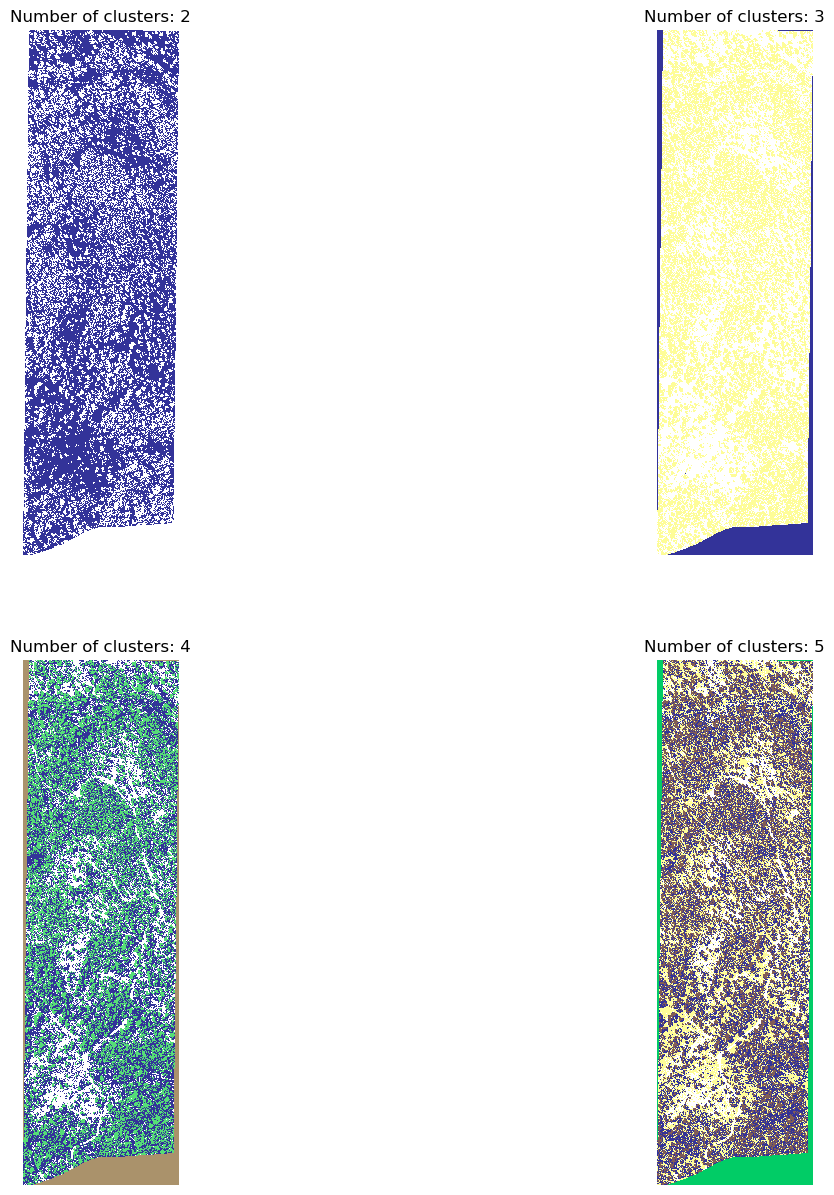

In [89]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load the TIFF file
with rasterio.open(cropped_file) as src:
    # Assuming bands 1 to 4 are RGB and NIR
    bands = [src.read(i) for i in range(1, 5)]
    image_data = np.dstack(bands)

# Prepare the data for clustering
pixels = image_data.reshape((-1, 4))  # Flatten the image data for clustering

# Dictionary to store predictions
predictions = {}

# Perform K-means clustering for 2 to n clusters
for k in range(2, 6): 
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    segmented_image = labels.reshape(image_data.shape[0], image_data.shape[1])
    predictions[k] = segmented_image

# Create a subplot grid and plot each clustering result
f, axes = plt.subplots(2, 2, figsize=(15, 15))  # Adjust subplot layout

for ax_i, (k, prediction) in enumerate(predictions.items()):
    if ax_i >= 6:
        continue
    ax = axes.flatten()[ax_i]
    im = ax.imshow(prediction, cmap="terrain", interpolation='none')
    ax.set_title("Number of clusters: " + str(k))
    ax.axis('off')  # Hide axis ticks

plt.show()

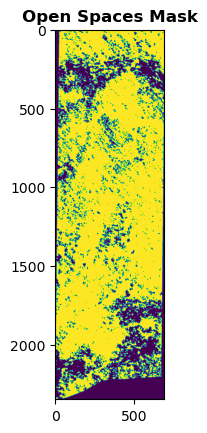

In [95]:
import rasterio
import numpy as np
from rasterio.plot import show
from skimage.morphology import opening, square
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import box

# Open the GeoTIFF file
with rasterio.open(cropped_file) as src:
    # Read the red and NIR bands (assuming band 4 is NIR)
    red = src.read(1).astype(float)
    nir = src.read(4).astype(float)

    # Calculate NDVI
    ndvi = (nir - red) / (nir + red)

    # Create a mask for non-vegetated areas (low NDVI values)
    open_space_mask = ndvi < 0.2  # Adjust the threshold based on the image characteristics

    # Apply morphological opening to clean up noise
    clean_mask = opening(open_space_mask, square(3))

    # Visualize the mask
    show(clean_mask, title='Open Spaces Mask')

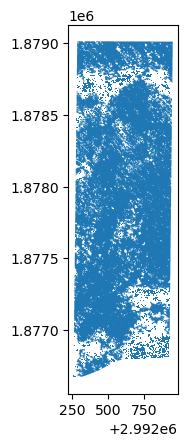

In [105]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes
from skimage.morphology import opening, square
from rasterio.plot import show

# Open the GeoTIFF file
with rasterio.open(cropped_file) as src:
    # Assuming your mask is already calculated and is named 'clean_mask'
    # If clean_mask is not defined, replace it with appropriate mask calculation code

    # Transform raster formatted boolean mask to vector format using rasterio.features.shapes
    mask_transformed = clean_mask.astype(np.uint8)  # Ensure the mask is in uint8 format
    results = shapes(mask_transformed, mask=mask_transformed, transform=src.transform)

    # Extract polygons and filter by value
    geometries = [shape(geom) for geom, value in results if value == 1]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame({
        'geometry': geometries
    }, crs=src.crs)

    # Optionally, filter by size to remove very small polygons
    # some_value could be any area threshold you decide is appropriate for your analysis
    # gdf = gdf[gdf.geometry.area > some_value]

    # Save to file or visualize
    gdf.to_file('scratch/open_spaces.shp')
    gdf.plot()


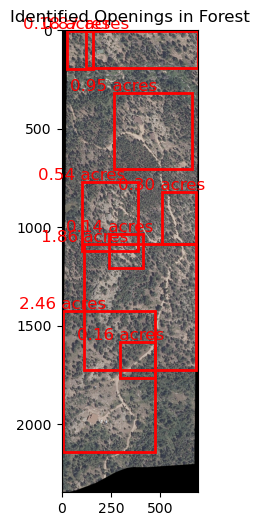

In [103]:
import numpy as np
import rasterio
from scipy.ndimage import binary_opening, generate_binary_structure
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

# Step 1: Load Image Data
with rasterio.open(cropped_file) as src:
    bands = [src.read(i) for i in range(1, 5)]  # Read RGB and NIR bands
    image_data = np.dstack(bands)  # Stack bands along the third dimension

# Step 2: Preprocess Data
# Define a simple threshold to differentiate vegetation
# Adjust this threshold based on your data's characteristics
threshold = image_data.mean(axis=2) > 120

# Step 3: Morphological Operations
# Define a structural element for morphological operations
structuring_element = generate_binary_structure(2, 1)  # Two-dimensional, single connectivity
# Apply morphological opening to clean up small holes in the vegetation
open_areas = binary_opening(threshold, structure=structuring_element)

# Step 4: Label and Measure Connected Components
label_image = label(open_areas)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_data[:, :, 0:3], cmap='gray')  # Display RGB for visualization

# Pixel area to acres conversion based on image resolution
pixel_area_to_acres = (src.res[0] * src.res[1]) / 43560  # Convert resolution from meters/pixels to acres

# Measure and visualize each region
for region in regionprops(label_image):
    if (region.area * pixel_area_to_acres) >= (1/8):  # Filter regions smaller than 1/8 acre
        minr, minc, maxr, maxc = region.bbox
        rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        area_acres = region.area * pixel_area_to_acres
        ax.text(minc, minr - 10, f'{area_acres:.2f} acres', color='red', fontsize=12, ha='center')

plt.title('Identified Openings in Forest')
plt.show()
